In [13]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip3 install transformers
!cp /content/drive/MyDrive/fake-news-explainability/utils_fake_news.py .

In [24]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

%run utils_fake_news.py

# Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

## Preprocess & Encode Data

In [6]:
# Load the Fake-News Kaggle dataset
df_pos = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Negation_Task/fake_news_positive.csv")
df_neg = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Negation_Task/fake_news_negative.csv")

# Relabel target
df_pos['target'] = df_pos['label']
df_neg['target'] = df_neg['label'].apply(lambda x: 0 if x==1 else 1)
df_train = df_pos.append(df_neg).reset_index(drop=True)

# Encode dataframes
df_train_encode = encode_dataframe(df_train['text'], df_train['target'])

torch.save(df_train_encode,
           "/content/drive/MyDrive/fake-news-explainability/Data/fake_news_encoded_negated.pt")

## Model & Training Function

In [4]:
import torch.nn as nn
from transformers import AutoModel
class FakeBERT(nn.Module):
    def __init__(self):
        super(FakeBERT, self).__init__()
        
        self.base_model = AutoModel.from_pretrained('bert-base-uncased')

        # Layer 1: Conv1D + Maxpool
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
        self.sigm_1 = nn.ReLU()
        self.pool_1 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 6: Fully Connected Layer 
        self.full_6 = nn.Linear(153,32)
        self.sigm_6 = nn.Sigmoid()
        
        # Layer 7: Fully Connected Layer 
        self.full_7 = nn.Linear(32,2)
        self.soft_7 = nn.Softmax()

    def forward(self, input_ids, attn_mask):
        bert_output = self.base_model(input_ids, attention_mask=attn_mask)
        bert_output = bert_output['pooler_output'].unsqueeze(1)
        bert_perturb = 0.1*torch.rand(768).to(device)
        bert_output = bert_output + bert_perturb
        outputs = self.pool_1(self.sigm_1(self.conv_1(bert_output)))
        outputs = self.sigm_6(self.full_6(outputs))
        outputs = self.soft_7(self.full_7(outputs))
        return outputs, bert_output

def train():
    total_t0 = time.time()
    for epoch_i in range(0, epochs):
        
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        bert_model.train()

        for step, batch in enumerate(bert_train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

            # Unpack batch
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Zero grads
            bert_model.zero_grad()        

            # Forward pass
            output, bert_output = bert_model(b_input_ids, b_input_mask)
            
            # Accumulate loss
            loss = loss_func(output.squeeze(1), b_labels)
            print(loss.detach())

            # Backpropagate
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The bert_optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            bert_optimizer.step()

            # Update the learning rate.
            bert_scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(bert_train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # Record all statistics from this epoch.
        bert_training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                # 'Valid. Loss': avg_val_loss,
                # 'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                # 'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Load Data

In [ ]:
# Run if the data has already been encoded
# Load encoded Fake-News Kaggle dataset
df_train_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/fake_news_pos_encoded.pt")

In [ ]:
# Load data into dataloader
batch_size = 32
bert_train_dataloader = DataLoader(
    df_train_encode,  # The training samples.
    batch_size = batch_size # Trains with this batch size.
    )

## Training

In [ ]:
# BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Model
bert_model = FakeBERT().to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Training Params
bert_training_stats = []
epochs = 2
total_steps = len(bert_train_dataloader) * epochs
loss_func = nn.CrossEntropyLoss()

# Learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps = 0, # Default value in run_glue.py
                                                 num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Train
train()

In [ ]:
# Save model
torch.save(bert_model.state_dict(),
           "/content/drive/MyDrive/fake-news-explainability/Models/bert_model_fake_news_perturbation_kaggle")

## Evaluate

In [16]:
# Load model if hasn't been trained
bert_model = FakeBERT().to(device)
bert_model.load_state_dict(torch.load(
    "/content/drive/MyDrive/fake-news-explainability/Models/bert_model_fake_news_kaggle"
    ))

# BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Load encoded tensors
df_pos_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_pos_encoded.pt")
df_neg_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_neg_encoded.pt")

In [18]:
# Load data into dataloader
batch_size = 32
bert_pos_dataloader = DataLoader(df_pos_encode, batch_size = batch_size)
bert_neg_dataloader = DataLoader(df_neg_encode, batch_size = batch_size)

In [20]:
# Generate predictions
# Can't input everything directly due to RAM issues
outputs_pos = []
outputs_neg = []
with torch.no_grad():
    for step, batch in enumerate(bert_pos_dataloader):
        # Unpack batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Forward pass
        output = bert_model(b_input_ids, b_input_mask)
        outputs_pos.append(output[0])
        
    for step, batch in enumerate(bert_neg_dataloader):
        # Unpack batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Forward pass
        output = bert_model(b_input_ids, b_input_mask)
        outputs_neg.append(output[0])
        
# Stack outputs
outputs_pos = torch.vstack(outputs_pos).squeeze(1)
outputs_neg = torch.vstack(outputs_neg).squeeze(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [27]:
# Positive statement accuracy
print(f"Positive Class Acc: {flat_accuracy(outputs_pos.detach().cpu().numpy(), df_pos_encode.tensors[2].to('cpu').numpy())}")

# Negative statement accuracy
print(f"Negative Class Acc: {flat_accuracy(outputs_neg.detach().cpu().numpy(), df_neg_encode.tensors[2].to('cpu').numpy())}")

Positive Class Acc: 0.9930048189025338
Negative Class Acc: 0.007357894191408881


## Results Log
* FakeBERT, Trained on positive and negative classes
  * Result on positive/negative: tensor(0.9990)
  * Result on fake-news dataset: ???



## Negation

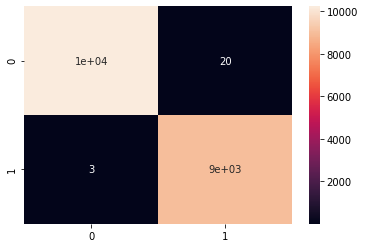

In [28]:
# Confusion matrix
cf_matrix = confusion_matrix(torch.argmax(outputs_pos.cpu(), axis=1), 
                             torch.argmax(outputs_neg.cpu(), axis=1))
sns.heatmap(cf_matrix, annot=True)